<a href="https://colab.research.google.com/github/EvgeniaKantor/MeNow/blob/main/Wordstat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [44]:
#read Excel file
df = pd.read_excel('Wordstat_Counries.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   №                                       201 non-null    int64 
 1   Country name in Russian                 201 non-null    object
 2   Country name in English                 201 non-null    object
 3   Region                                  201 non-null    object
 4   Which?                                  152 non-null    object
 5   Number of requests for 19.09-19.10 (D)  201 non-null    int64 
 6   Number of requests for 19.09-19.10 (A)  201 non-null    int64 
 7   Sum                                     201 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 12.7+ KB


In [17]:
import google.generativeai as genai
import os
import time
import re
from google.api_core.exceptions import ServiceUnavailable
from google.colab import userdata

# Retrieve and set the API key
GOOGLE_API_KEY = userdata.get('gemini_key')
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

# Configure the generative AI client
genai.configure(api_key=GOOGLE_API_KEY)

# Load the generative model
model = genai.GenerativeModel('gemini-pro')

# Function to translate country names and print the result
def get_english_translate(country_name):
    query = f"Translate the country name from Russian to English:\n{country_name}"
    retries = 3  # Number of retries
    delay = 5  # Initial delay in seconds

    while retries > 0:
        try:
            # Send request to generative model
            response = model.generate_content(query)

            # Check response structure and handle content accordingly
            if response and response.candidates:
                # Extract 'text' from the 'parts' using the first candidate
                content_parts = response.candidates[0].content.parts
                if content_parts and len(content_parts) > 0:
                    # Access the 'text' field from the first part (which is a dict-like object)
                    return content_parts[0].text.strip()  # Safely extract and strip whitespace
                else:
                    print(f"Unexpected content type for {country_name}: {type(content_parts)}")
                    return None
            else:
                print(f"No valid content found for country_name: {country_name}")
                return None
        except (IndexError, AttributeError) as e:
            print(f"Error parsing response: {str(e)}")
            return None
        except ServiceUnavailable as e:
            print(f"Service unavailable. Retrying in {delay} seconds...")
            time.sleep(delay)
            retries -= 1
            delay *= 2  # Exponential backoff
        except Exception as e:
            print(f"Exception: {str(e)}")
            return None

    print(f"Maximum retries reached. Unable to generate translation.")
    return None


# Ensure df is defined and contains necessary columns
if 'Country name in Russian' not in df.columns or 'Country name in English' not in df.columns:
    raise ValueError("DataFrame must contain 'Country name in Russian' and 'Country name in English' columns.")

# Rate limiting parameters
delay_between_requests = 1  # Delay in seconds between requests

# Generate translation for each country name in Russian
for index, row in df.iterrows():
    try:
        # Check if the English name is empty
        if pd.isna(row['Country name in English']) or row['Country name in English'] == '':
            # Get translation for the country name in Russian
            russian_name = row.get('Country name in Russian', '')
            new_name = get_english_translate(russian_name)

            if new_name:
                # Update DataFrame with the translated name
                df.at[index, 'Country name in English'] = new_name
                # Print in the format: "RussianName: EnglishName"
                print(f"{russian_name}: {new_name}")

            # Delay between requests to avoid rate-limiting issues
            time.sleep(delay_between_requests)
    except Exception as e:
        print(f"Failed to translate {index}: {e}")

Фиджи: Fiji
Шри-Ланка: Sri Lanka


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   №                                       201 non-null    int64 
 1   Country name in Russian                 201 non-null    object
 2   Country name in English                 201 non-null    object
 3   Region                                  201 non-null    object
 4   Which?                                  152 non-null    object
 5   Number of requests for 19.09-19.10 (D)  201 non-null    int64 
 6   Number of requests for 19.09-19.10 (A)  201 non-null    int64 
 7   Sum                                     201 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 12.7+ KB


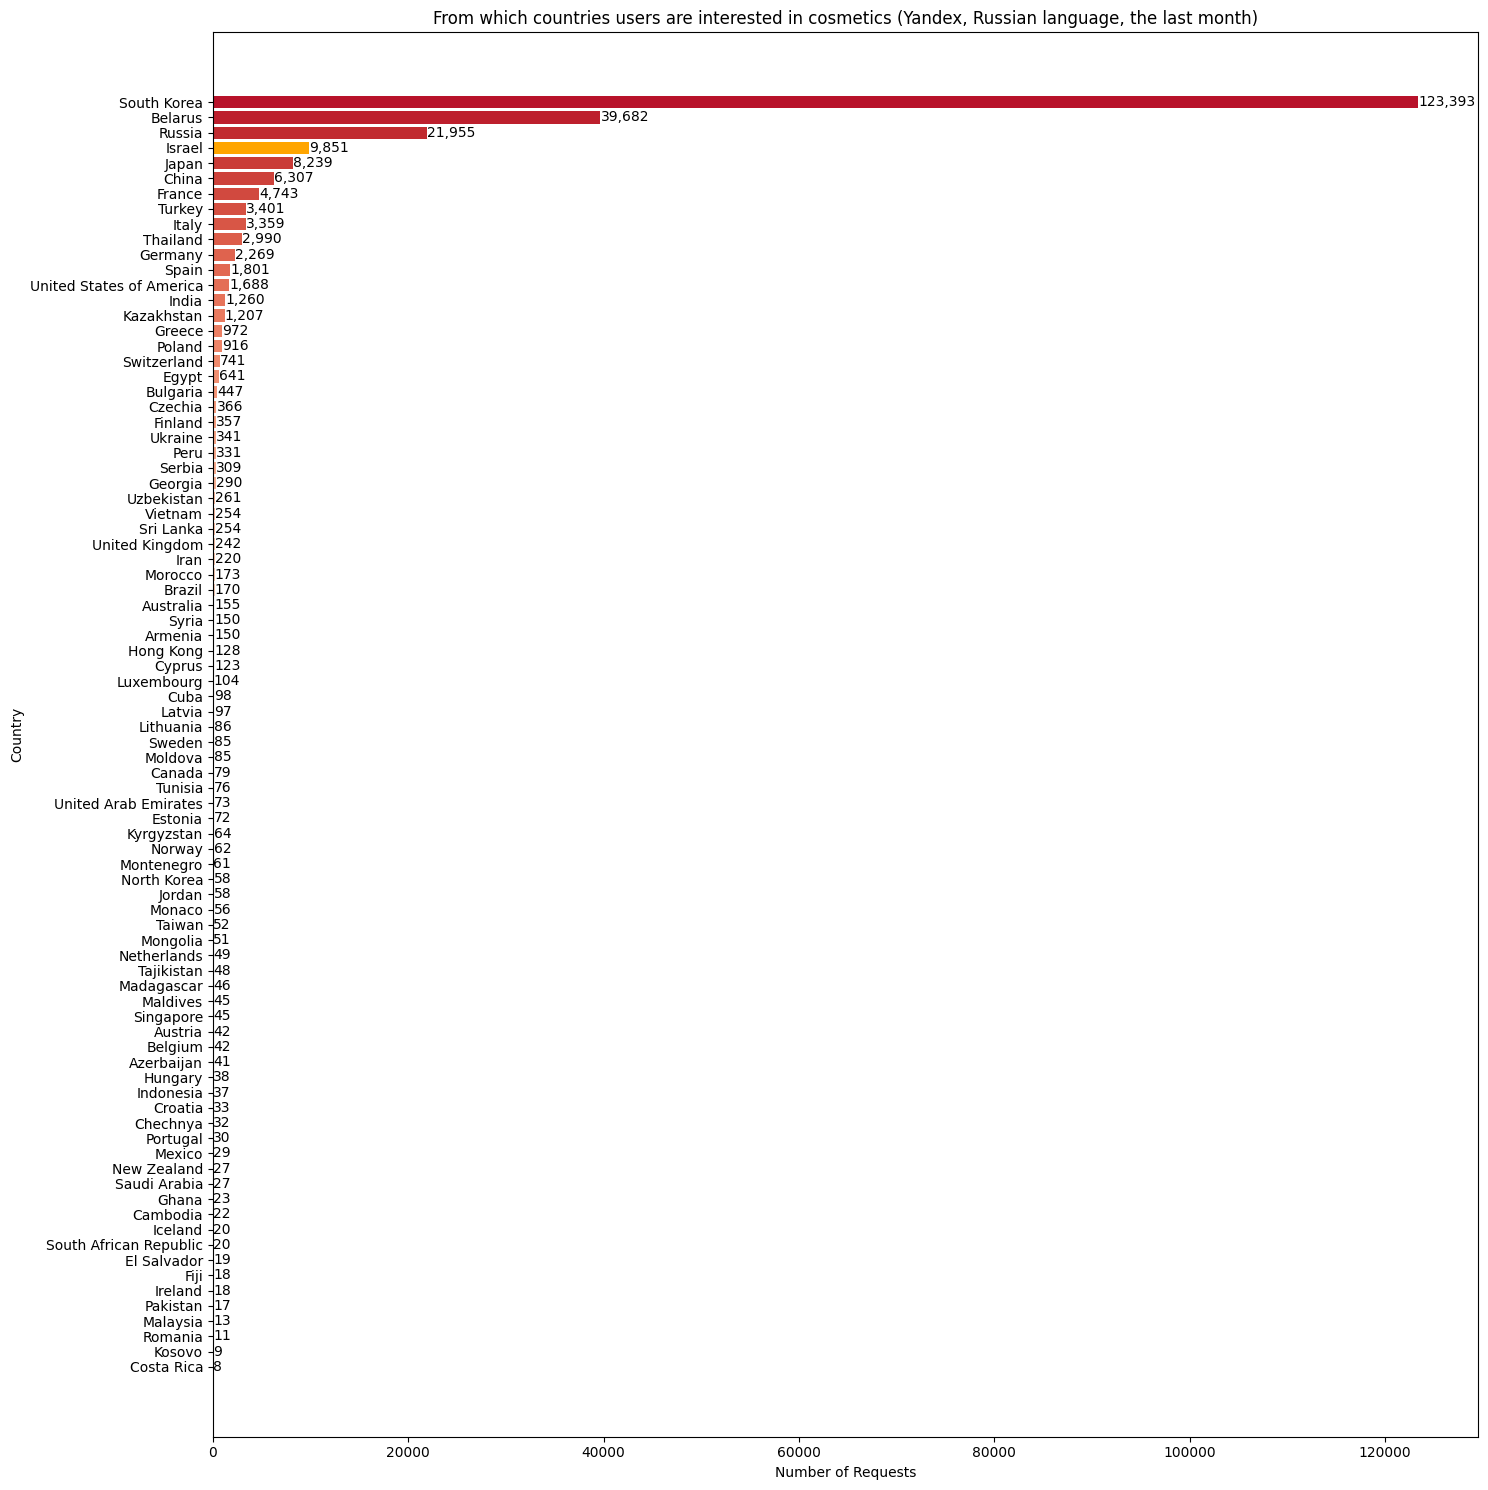

In [45]:
#visualize countries where Sum is more then 0
# Step 1: Filter the DataFrame where Sum > 0
df_filtered = df[df['Sum'] > 0]

# Step 2: Sort the DataFrame by 'Sum' for better visualization
df_filtered_sorted = df_filtered.sort_values(by='Sum', ascending=True)

# Step 3: Create a color palette
colors = sns.color_palette('coolwarm', n_colors=len(df_filtered_sorted))

# Step 4: Assign a different color for Israel
color_map = {country: color for country, color in zip(df_filtered_sorted['Country name in English'], colors)}
color_map['Israel'] = 'orange'  # Change this color to whatever you prefer

# Create a list of colors for the bars
bar_colors = [color_map[country] for country in df_filtered_sorted['Country name in English']]

# Step 5: Create the horizontal bar chart
plt.figure(figsize=(15, 15))
bars = plt.barh(df_filtered_sorted['Country name in English'], df_filtered_sorted['Sum'], color=bar_colors)

# Step 6: Annotate each bar with the 'Sum' value as an integer
for bar in bars:
    plt.text(
        bar.get_width(),  # X-coordinate (right edge of bar)
        bar.get_y() + bar.get_height()/2,  # Y-coordinate (middle of the bar)
        f'{int(bar.get_width()):,}',  # Text to display (formatted as integer)
        va='center',  # Vertical alignment
        ha='left',    # Horizontal alignment
        fontsize=10   # Font size for readability
    )

# Step 7: Customize the chart
plt.xlabel('Number of Requests')
plt.ylabel('Country')
plt.title('From which countries users are interested in cosmetics (Yandex, Russian language, the last month)')
# plt.grid(True)  # Remove or comment out this line to eliminate grid lines

# Step 8: Show the chart
plt.tight_layout()
plt.show()

In [32]:
# Filter the DataFrame where Sum > 0
df_filtered = df[df['Sum'] > 0]

# Create a choropleth map using Plotly
fig = px.choropleth(df_filtered,
                    locations='Country name in English',
                    locationmode='country names',
                    color='Sum',
                    hover_name='Country name in English',
                    color_continuous_scale='Viridis',
                    title='World Map of Countries with Sum > 0')

# Show the map
fig.show()

In [33]:
# Assuming df has a 'Country name in English' and 'Sum' column
df_filtered = df[df['Sum'] > 0]

# Create a bubble map
fig = px.scatter_geo(df_filtered,
                     locations='Country name in English',
                     locationmode='country names',
                     size='Sum',
                     hover_name='Country name in English',
                     projection='natural earth',
                     title='Bubble Map of Countries with Sum > 0')

# Show the map
fig.show()